In [1]:
!pip install langchain langchain_core langchain_groq langchain_community 

     ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
     ---- ----------------------------------- 0.1/1.0 MB 2.4 MB/s eta 0:00:01
     ---------- ----------------------------- 0.3/1.0 MB 2.8 MB/s eta 0:00:01
     ----------------- ---------------------- 0.5/1.0 MB 3.1 MB/s eta 0:00:01
     ------------------------ --------------- 0.6/1.0 MB 3.2 MB/s eta 0:00:01
     ------------------------------- -------- 0.8/1.0 MB 3.4 MB/s eta 0:00:01
     ------------------------------------- -- 0.9/1.0 MB 3.5 MB/s eta 0:00:01
     ---------------------------------------- 1.0/1.0 MB 3.2 MB/s eta 0:00:00
     ---------------------------------------- 0.0/444.0 kB ? eta -:--:--
     -------------- ----------------------- 163.8/444.0 kB 3.3 MB/s eta 0:00:01
     -------------------------- ----------- 307.2/444.0 kB 3.2 MB/s eta 0:00:01
     -------------------------------------- 444.0/444.0 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.5 MB ? eta -:--:--


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install langgraph

     ---------------------------------------- 0.0/153.3 kB ? eta -:--:--
     ------------------------- ------------ 102.4/153.3 kB 3.0 MB/s eta 0:00:01
     -------------------------------------- 153.3/153.3 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/43.9 kB ? eta -:--:--
     ---------------------------------------- 43.9/43.9 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/54.6 kB ? eta -:--:--
     ---------------------------------------- 54.6/54.6 kB ? eta 0:00:00
     ---------------------------------------- 0.0/121.2 kB ? eta -:--:--
     -------------------------------------- 121.2/121.2 kB 6.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import os
from typing import TypedDict , Annotated , List
from langgraph.graph import StateGraph,END 
from langchain_core.messages import HumanMessage , AIMessage
from langchain_core.prompts import ChatMessagePromptTemplate , ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display,Image

In [10]:
class PlanState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage],"conversation"]
    city : str
    interest : List[str]
    itinerary : str

In [11]:
!pip install python-dotenv



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

llm = ChatGroq(
    temperature = 0,
    groq_api_key = os.getenv("GROQ_API"),
    model_name = "llama-3.3-70b-versatile",
)



In [14]:
ChatPromptTemplate.from_messages([
    ("system","You are a helpful assistant. Creae a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."),
    ("human","create an itinerary for my day trip")
])

ChatPromptTemplate(input_variables=['city', 'interests'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['city', 'interests'], input_types={}, partial_variables={}, template="You are a helpful assistant. Creae a day trip itinerary for {city} based on the user's interests: {interests}. Provide a brief, bulleted itinerary."), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='create an itinerary for my day trip'), additional_kwargs={})])

In [15]:
def cityinput(state:PlanState) -> PlanState:
    print("Please enter the city you want to visit for your day trip: ")
    user_message = input("Your Input: ")
    return {
        **state,
        "city": user_message,
        "messages": state['messages'] + [HumanMessage(content=user_message)]
    }

def interestsinput(state:PlanState) -> PlanState:
    print(f"Please enter the city: {state['city']} (comma-separted)")
    user_message = input("input: ")
    return {**state,"interests":[interest.strip() for interest in user_message.split(",")],"messages": state["messages"] + [HumanMessage(content=user_message)]}

def itinerary(state:PlanState) -> PlanState:
    print(f"Creating an itinerary for {state['city']} based on interests : {', '.join(state['interests'])}")
    response = llm.invoke(itinerary_prompt.format_messages(city = state['city'], interests = ','.join(state['interests'])))
    print("\nFinal Itinerary: ")
    print(response.content)
    return {**state,"messages": state["messages"] + [AIMessage(content=response.content)],"itinerary":response.content}

In [18]:
workflow = StateGraph(PlanState)

workflow.add_node("cityinput",cityinput)
workflow.add_node("interestsinput",interestsinput)
workflow.add_node("itinerary",itinerary)

workflow.set_entry_point("cityinput")

workflow.add_edge("cityinput","interestsinput")
workflow.add_edge("interestsinput","itinerary")
workflow.add_edge("itinerary",END)

app = workflow.compile()

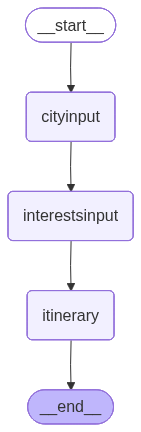

In [19]:
display(
    Image(app.get_graph().draw_mermaid_png(
        draw_method=MermaidDrawMethod.API
    ))
)